## EDA

In [1]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import calplot
from datetime import datetime

# statistics
import scipy
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# working with files
import sys
import os

# to off warnings
import warnings
warnings.filterwarnings('ignore')

#clusterization
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# data preprocessing
from itertools import product
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# using ray engine for parallel calculation(for oprimization)
%env MODIN_ENGINE=ray
import modin.pandas as mpd

env: MODIN_ENGINE=ray


In [3]:
# add data path to sys.path 
data_path = "C:\\Repository\\DS-Intership-data\\clean_data\\"
sys.path.append(data_path)

# initiate dict for data
to_read = {}

# fill to_read
for dir_name, _, files in os.walk(data_path):
    for file in files:
        to_read[file] = dir_name + file

In [4]:
# check to_read
to_read

{'all_data.csv': 'C:\\Repository\\DS-Intership-data\\clean_data\\all_data.csv',
 'items.csv': 'C:\\Repository\\DS-Intership-data\\clean_data\\items.csv',
 'item_categories.csv': 'C:\\Repository\\DS-Intership-data\\clean_data\\item_categories.csv',
 'sales_train.csv': 'C:\\Repository\\DS-Intership-data\\clean_data\\sales_train.csv',
 'sample_submission.csv': 'C:\\Repository\\DS-Intership-data\\clean_data\\sample_submission.csv',
 'shops.csv': 'C:\\Repository\\DS-Intership-data\\clean_data\\shops.csv',
 'test.csv': 'C:\\Repository\\DS-Intership-data\\clean_data\\test.csv'}

In [5]:
%%time
data = {}
# read data using engine pyarrow for acceleration 
for file, path in to_read.items():
    data[file.split('.')[0]] = mpd.read_csv(os.path.join(os.path.dirname(path), file), index_col=0)

2023-09-06 15:38:28,766	INFO worker.py:1621 -- Started a local Ray instance.


CPU times: total: 625 ms
Wall time: 8.51 s


In [6]:
# rebuild df from pandas to modin
for df in data.values():
    df = mpd.DataFrame(df)

### Item categories

In [7]:
# we can try to check what categories have low/high sales
data['item_categories'].head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

What item's categories have low/high sales?

In [8]:
sales_data = data['sales_train'].merge(
        data['items'], how='left', on='item_id'
        ).merge(
                data['item_categories'], how='left', on='item_category_id'
                ).drop(columns=['shop_id', 'year_month', 'item_name'])
sales_data.head(2)

date  date_block_num  item_id  item_price  item_cnt_day  \
0  2013-01-02               0    22154      999.00          1.00   
1  2013-01-03               0     2552      899.00          1.00   

   item_category_id item_category_name  
0                37     Кино - Blu-Ray  
1                58     Музыка - Винил

In [9]:
# data selection
g = mpd.DataFrame(sales_data.groupby(['item_category_id'])['item_cnt_day'].agg(sum))\
                 .rename(columns={'item_cnt_day':'category_sales'}).reset_index()\
                 .merge(data['item_categories'], on='item_category_id', how='left')\
                 .sort_values(by='category_sales', ascending=False)

g["type_code"] = g.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)
g["split"] = g.item_category_name.apply(lambda x: x.split("-"))
g["subtype"] = g.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
g = g.drop(columns=['split'])
type_code_g = g.groupby('type_code')['category_sales'].agg(sum).sort_values(ascending=False)
subtype_g = g.groupby('subtype')['category_sales'].agg(sum).sort_values(ascending=False)

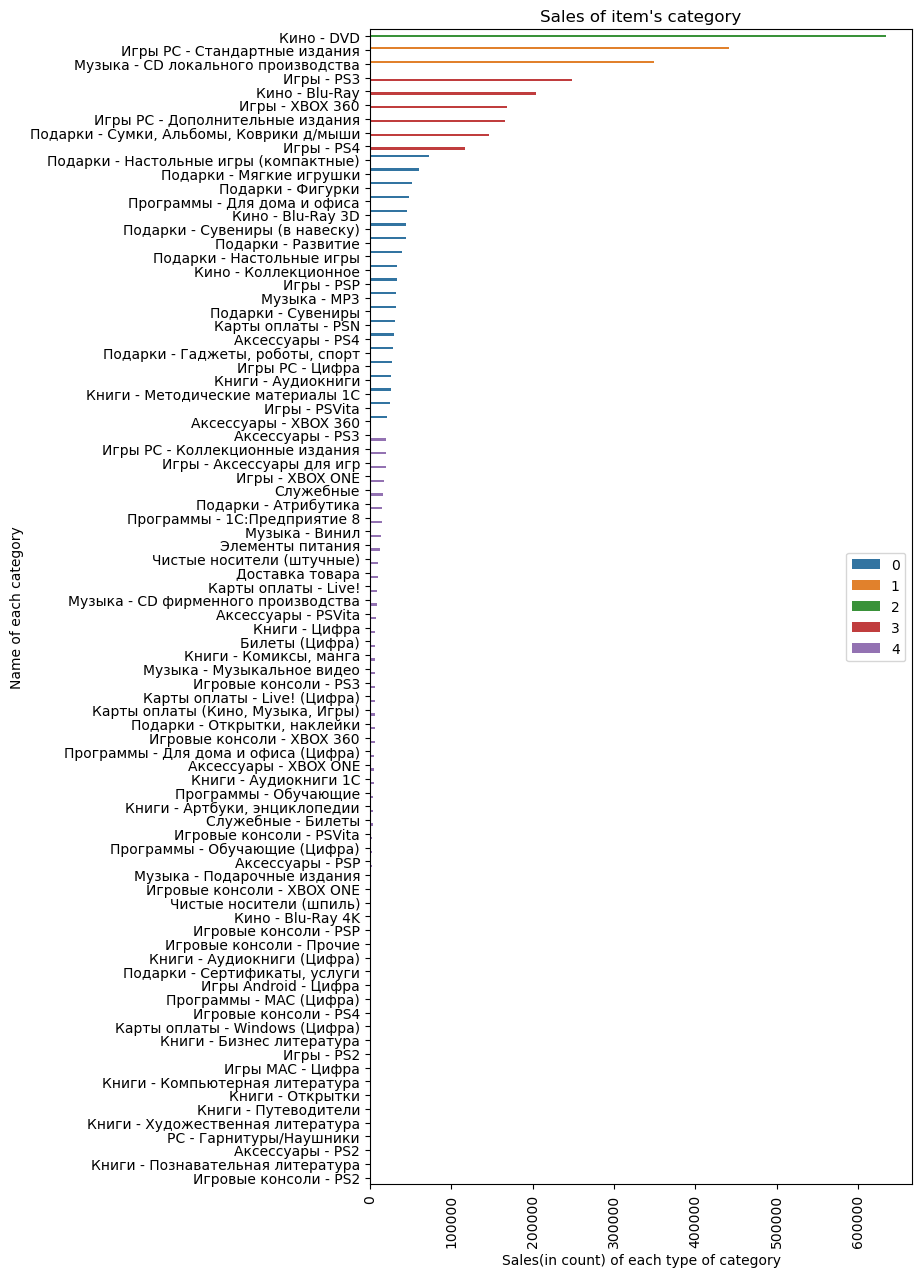

In [10]:
#clusterization
km = KMeans(n_clusters= 5, random_state=42, n_init="auto").fit(g.category_sales.to_numpy().reshape(-1, 1))

# visualization
plt.figure(figsize=(7, 15))
ax = sns.barplot(y=g.item_category_name.to_numpy(), x=g.category_sales.to_numpy(), hue= km.labels_)
ax.set(ylabel='Name of each category', xlabel='Sales(in count) of each type of category', title="Sales of item's category")
ax.tick_params(axis='x', rotation=90)
plt.show()

A few item categories have huge sales when other have poor sales, we can higlight the categories with the highest sales using clusterization. Also we can additionaly check sales of categories in split by type code and subtype. 

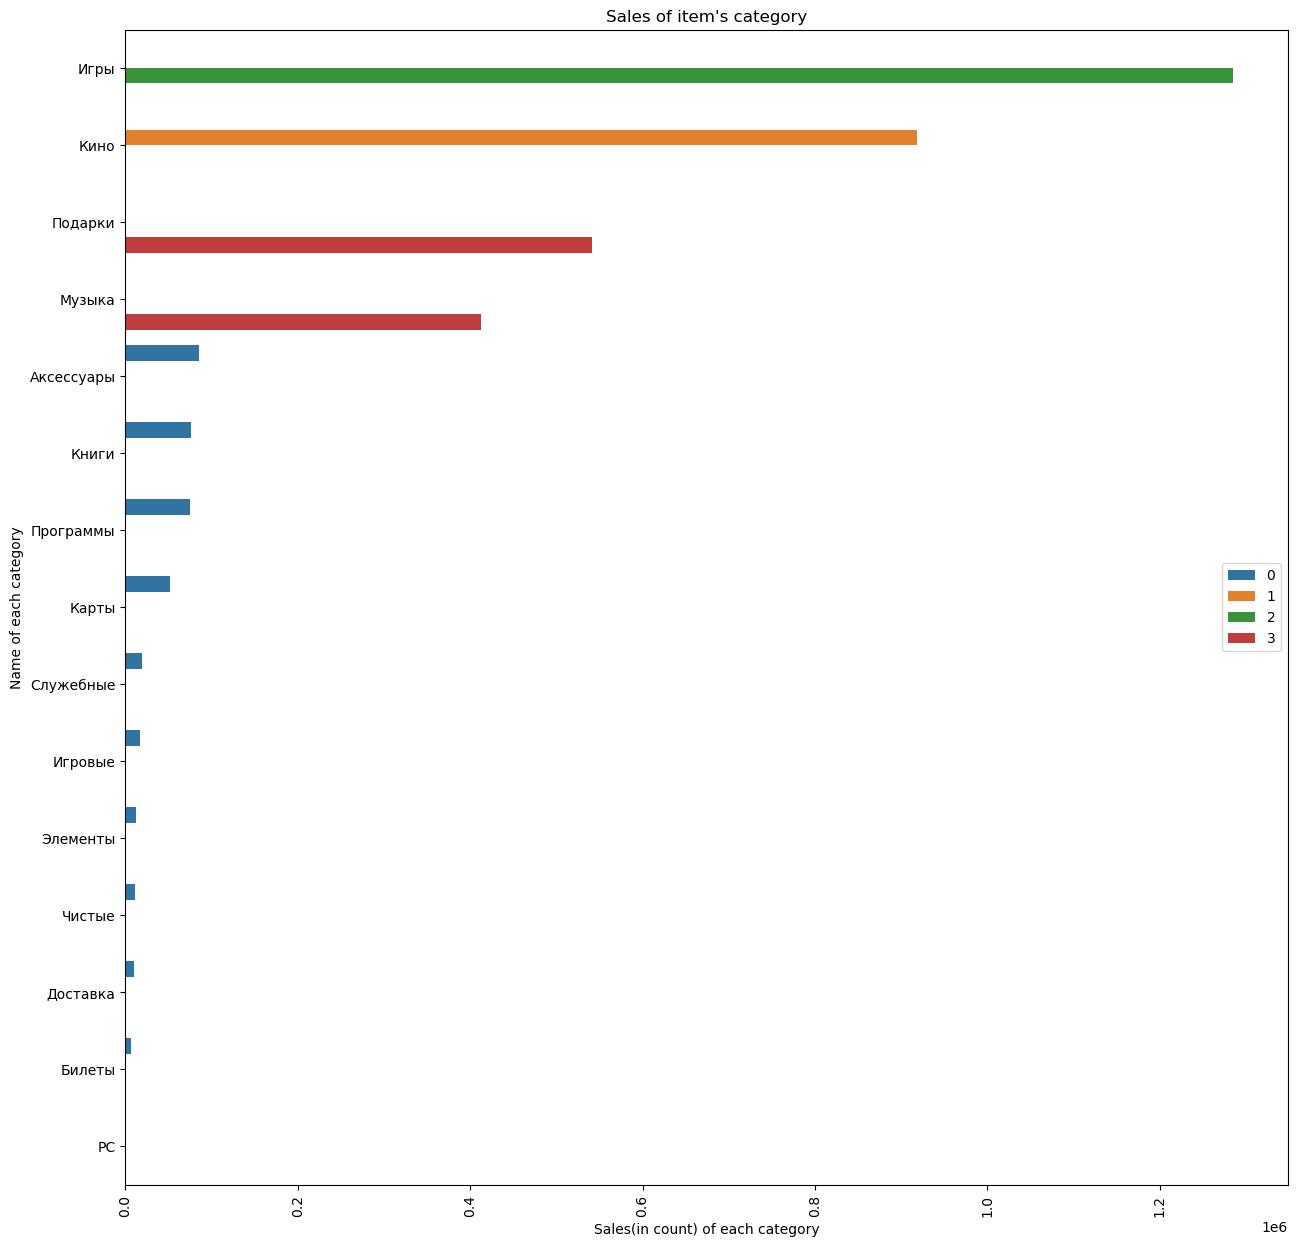

In [11]:
#clusterization
km = KMeans(n_clusters= 4, random_state=42, n_init="auto").fit(type_code_g.to_numpy().reshape(-1, 1))

# visualization
plt.figure(figsize=(15, 15))
ax = sns.barplot(y=type_code_g.index.to_numpy(), x=type_code_g.to_numpy(), hue= km.labels_)
ax.set(ylabel='Name of each category', xlabel='Sales(in count) of each category', title="Sales of item's type code")
ax.tick_params(axis='x', rotation=90)
plt.show()

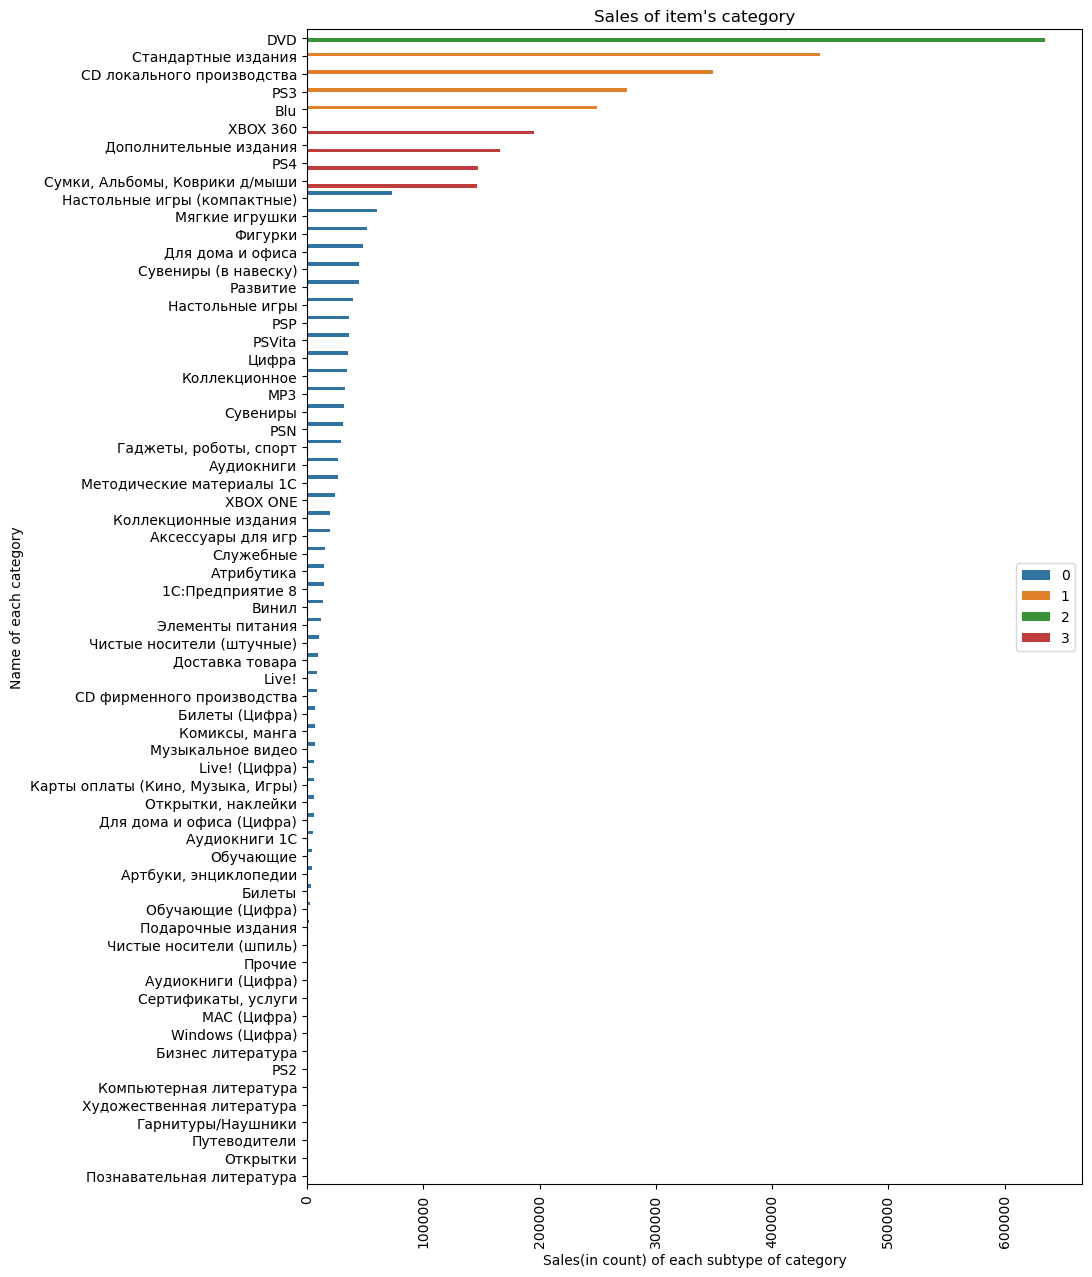

In [12]:
#clusterization
km = KMeans(n_clusters= 4, random_state=42, n_init="auto").fit(subtype_g.to_numpy().reshape(-1, 1))

# visualization
plt.figure(figsize=(10, 15))
ax = sns.barplot(y=subtype_g.index.to_numpy(), x=subtype_g.to_numpy(), hue= km.labels_)
ax.set(ylabel='Name of each category', xlabel='Sales(in count) of each subtype of category', title="Sales of item's subtype")
ax.tick_params(axis='x', rotation=90)
plt.show()

According to these plots, the marketability of subtype and type code of categories can be divided into 4 types.

### Items

In [13]:
# we can try to check what items have high sales
data['items'].head(5)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [14]:
sales_data = data['sales_train'].merge(
        data['items'], how='left', on='item_id'
        ).merge(
                data['item_categories'], how='left', on='item_category_id'
                ).drop(columns=['shop_id', 'year_month', 'item_name'])
sales_data.head(2)

date  date_block_num  item_id  item_price  item_cnt_day  \
0  2013-01-02               0    22154      999.00          1.00   
1  2013-01-03               0     2552      899.00          1.00   

   item_category_id item_category_name  
0                37     Кино - Blu-Ray  
1                58     Музыка - Винил

[Text(0.5, 0, 'Sales of items'),
 Text(0, 0.5, 'sales(in count) of each item'),
 Text(0.5, 1.0, 'Sales of items')]

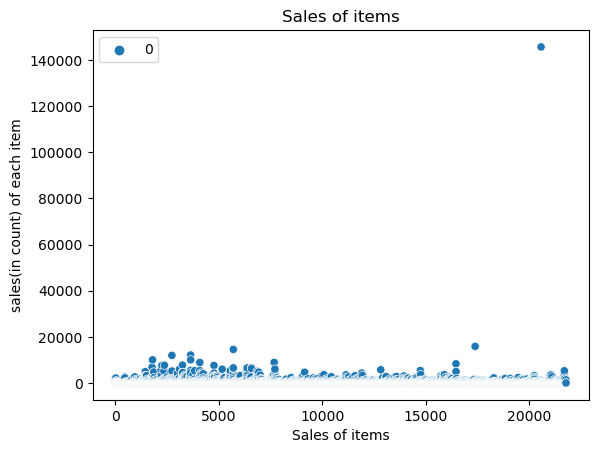

In [15]:
g = mpd.DataFrame(sales_data.groupby(['item_id'])['item_cnt_day'].agg(sum))\
                 .rename(columns={'item_cnt_day':'item_sales'})
ax = sns.scatterplot(g)
ax.set(xlabel='Sales of items', ylabel='sales(in count) of each item', title="Sales of items")

One item has extremely huge sales, need to check what is it

In [16]:
g[g.item_sales > 100000].item_sales

item_id
20949   145695.00
Name: item_sales, dtype: float64

In [17]:
data['items'][data['items'].item_id == 20949]

item_name  item_id  \
20949  Фирменный пакет майка 1С Интерес белый (34*42)...    20949   

       item_category_id  
20949                71

In [18]:
data['test'][data['test'].item_id == 20949].item_id.count()

42

We have to predict sales of this item for 42 shops so we cant remove information about this item

Check items sales without item with id 20949

[Text(0.5, 0, 'Sales of items'),
 Text(0, 0.5, 'sales(in count) of each item'),
 Text(0.5, 1.0, 'Sales of items')]

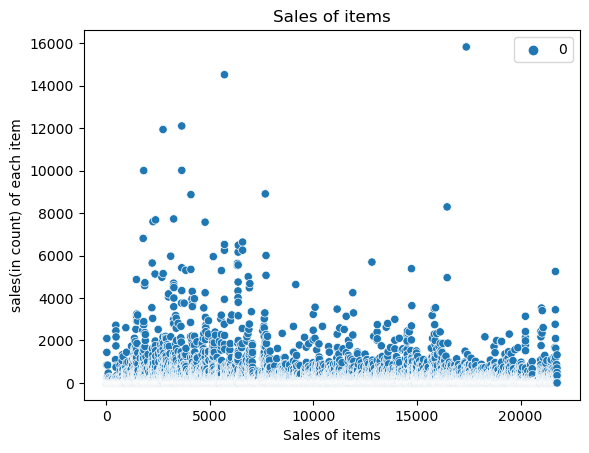

In [19]:
ax = sns.scatterplot(g[(g.index != 20949)])
ax.set(xlabel='Sales of items', ylabel='sales(in count) of each item', title="Sales of items")

Because amount of items is too huge need to try use histplot

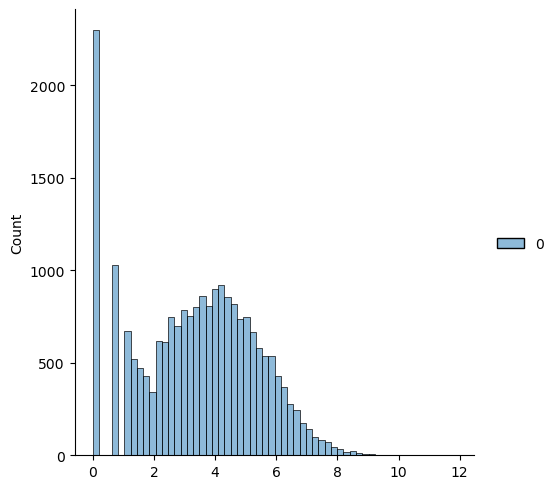

In [20]:
sns.displot(np.log(g))
ax.set(title="Distribution of sales of items")

The distribution of sales of goods in general looks normal, if you do not take into account the records of no sales of goods (i.e., where item_cnt_day is zero)

###### Сhecking of sales (in count) distributuon:

In [21]:
day_sales = data['sales_train']
np.sort(day_sales.item_cnt_day.unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

CPU times: total: 500 ms
Wall time: 540 ms


[Text(0.5, 0, 'Distribution of sales of items per day'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Sales(in count) of items per day')]

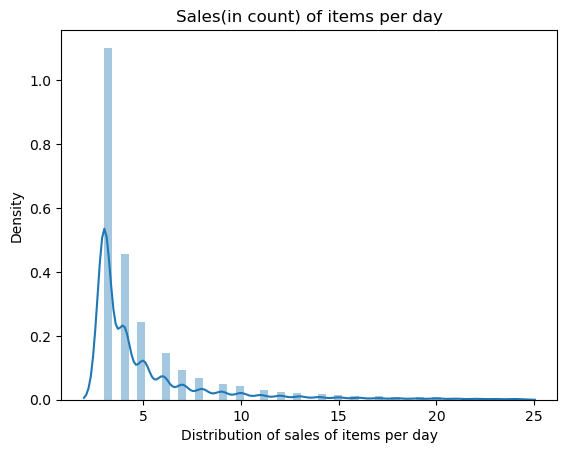

In [22]:
%%time
"""
as 75% of item_cnt_months is 2 so in the next parts of EDA we should cut left tail to look at right tail better
"""
ax = sns.distplot(day_sales[day_sales.item_cnt_day > 2].item_cnt_day)
ax.set(xlabel='Distribution of sales of items per day', ylabel="Density", title="Sales(in count) of items per day")

Amount of sales per day presents by exponential distribution with very long tail. Check count of days by months when item_cnt_day is more than 20

[Text(0.5, 0, 'Lineplot of sales of items per month'),
 Text(0, 0.5, 'Count of items'),
 Text(0.5, 1.0, 'month')]

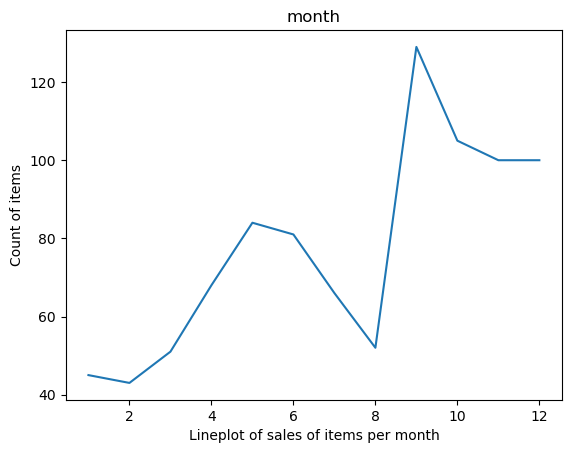

In [23]:
sales_data['month'] = mpd.DatetimeIndex(sales_data['date']).month
days_with_high_sales_by_month = sales_data[sales_data.item_cnt_day > 20].groupby('month')['item_cnt_day'].count()
df = pd.DataFrame({'month': days_with_high_sales_by_month.index, 'count': days_with_high_sales_by_month.values})
ax = sns.lineplot(data=df, x='month', y='count')
del(df)
ax.set(xlabel='Lineplot of sales of items per month', ylabel="Count of items", title="Number of days by month with sales over 20")

Days with a lot of sales fall on the 9th, 10th, 11th, 12th month.

Сhecking of sales (in price) distributuon

In [24]:
sales_data.item_price.describe()

count   2924482.00
mean        822.94
std        1191.32
min           0.07
25%         249.00
50%         399.00
75%         999.00
max       17791.68
Name: item_price, dtype: float64

CPU times: total: 27.2 s
Wall time: 29.1 s


Text(0.5, 1.0, 'Logarithmic distribution of item sales (in price)')

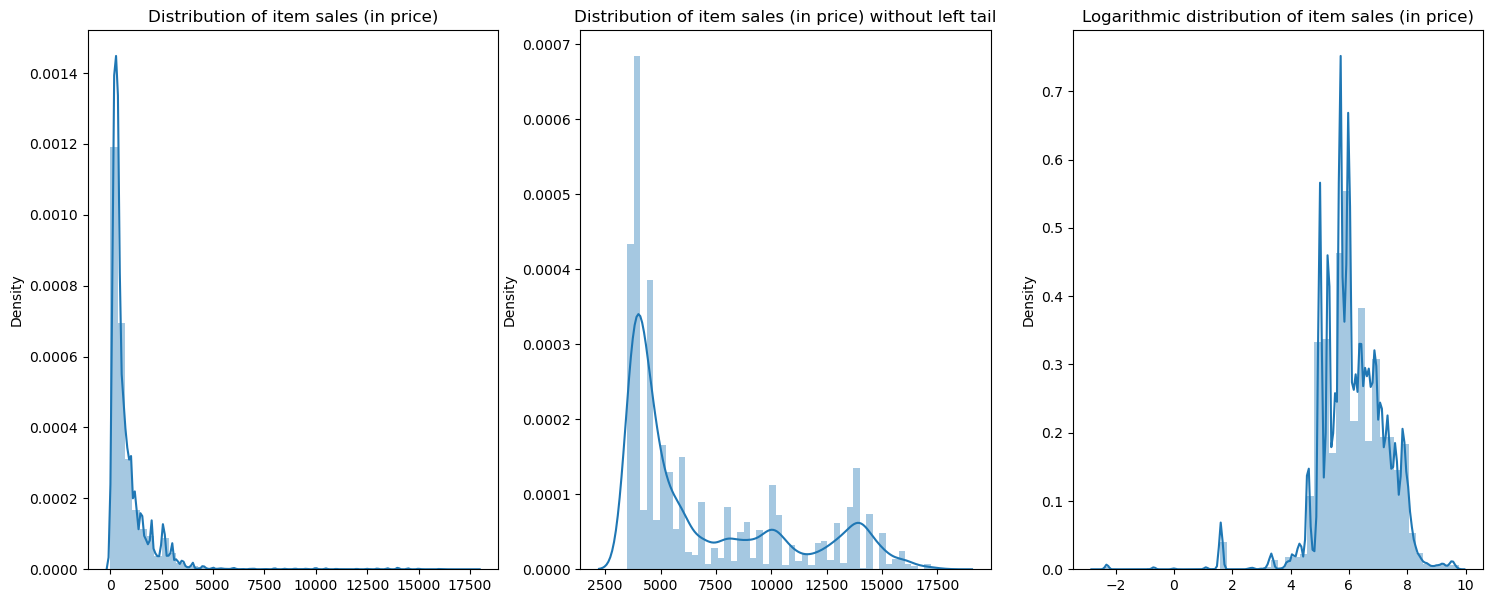

In [25]:
%%time
fig, axes = plt.subplots(1, 3, figsize=(18, 7))
sns.distplot(ax=axes[0], x=sales_data.item_price)
sns.distplot(ax=axes[1], x=sales_data[sales_data.item_price > 3500].item_price)
sns.distplot(ax=axes[2], x=np.log(sales_data[sales_data.item_price > 0].item_price))
axes[0].set_title("Distribution of item sales (in price)")
axes[1].set_title("Distribution of item sales (in price) without left tail")
axes[2].set_title("Logarithmic distribution of item sales (in price)")

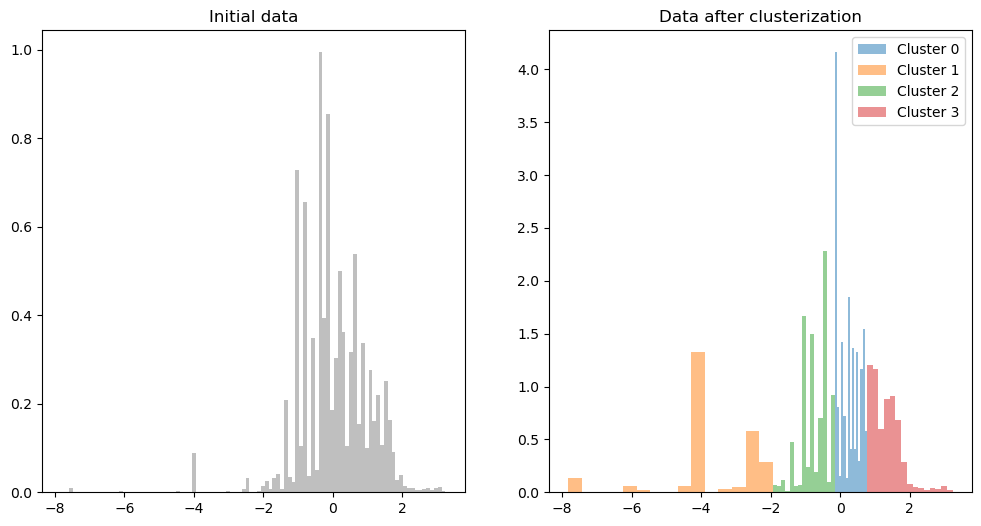

In [26]:

scaler = StandardScaler()
norm_prices = scaler.fit_transform(mpd.DataFrame(np.log(sales_data.item_price)))
n_components = 4

gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(norm_prices)
items_value = gmm.predict(norm_prices)

# show inittial data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(norm_prices, bins=100, density=True, alpha=0.5, color='gray')
plt.title('Initial data')

# show clusters
plt.subplot(1, 2, 2)
for cluster_label in range(n_components):
    cluster_data = norm_prices[items_value == cluster_label]
    plt.hist(cluster_data, bins=15, density=True, alpha=0.5, label=f'Cluster {cluster_label}')
plt.title('Data after clusterization')
plt.legend()

plt.show()


Сlustered items by price

Check for distribution of price of items

CPU times: total: 312 ms
Wall time: 636 ms


[Text(0.5, 0, 'Distribution of price sales per day'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'sales(in price) of each item')]

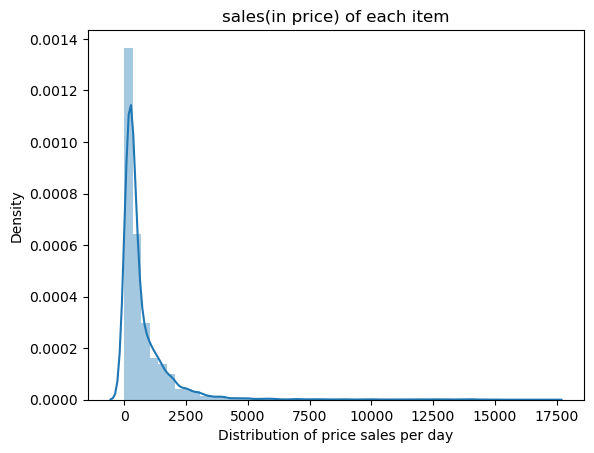

In [27]:
%%time
items_price = sales_data[sales_data.item_cnt_day == 1].drop_duplicates('item_id')
ax = sns.distplot(items_price.item_price)
ax.set(xlabel='Distribution of price sales per day', ylabel="Density", title="sales(in price) of each item")

A lot of items are cheap, need to check how price is affects sales

In [28]:
items_price_data = sales_data.merge(mpd.DataFrame(items_price[['item_price', 'item_id']])\
                                    .rename(columns={'item_price':'price_of_one_item'}), on='item_id', how='left')\
                                    .drop_duplicates('item_id').dropna()

In [29]:
data['sales_train'].item_id.nunique() - items_price_data.shape[0]

87

87 items have never sold in one copy(we can get price of this items by division)

In [30]:
items_sales_info = sales_data.groupby('item_id')['item_cnt_day'].count().reset_index()
corr_price_sales = items_sales_info.merge(items_price_data[['price_of_one_item', 'item_id']], on='item_id', how='inner')

In [31]:
corr_price_sales=corr_price_sales.groupby('item_id')[['item_cnt_day', 'price_of_one_item']].agg(sum).sort_values(by='item_cnt_day')
corr_price_sales.tail()

item_cnt_day  price_of_one_item
item_id                                 
4181             6853             999.00
2808             7354             999.00
17717            9067             999.00
5822             9408             999.00
20949           30304               5.00

In [32]:
corr_price_sales.corr()

item_cnt_day  price_of_one_item
item_cnt_day               1.00               0.03
price_of_one_item          0.03               1.00

No correlation between price of item and sales of this item

###### Checking for corr between time and sales:

In [33]:
month_sales = mpd.DataFrame(sales_data.groupby(["date_block_num"])['item_cnt_day'].agg(sum))\
    .rename(columns={"item_cnt_day":"item_cnt_month"}).reset_index()
month_sales.describe()

date_block_num  item_cnt_month
count           34.00           34.00
mean            16.50       103570.94
std              9.96        27838.83
min              0.00        62806.00
25%              8.25        84976.25
50%             16.50       104941.50
75%             24.75       121206.50
max             33.00       176274.00

[Text(0.5, 0, 'Month number'),
 Text(0, 0.5, 'Amount'),
 Text(0.5, 1.0, 'Sales of all items per month')]

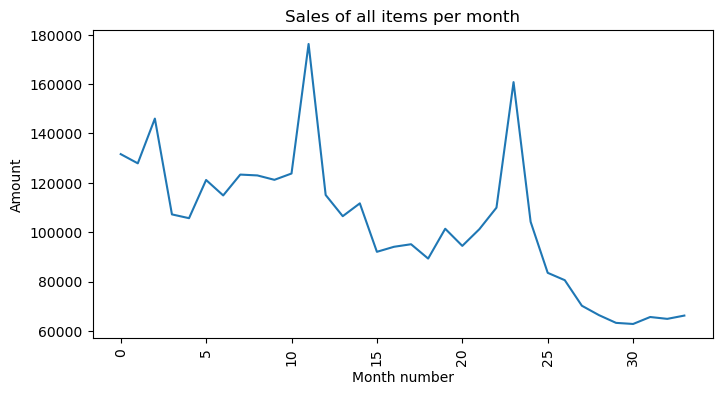

In [34]:
fig, ax = plt.subplots(figsize=(8,4))
g_by_months = sns.lineplot(y= month_sales.item_cnt_month, x = month_sales.date_block_num)
cnt = g_by_months.set_xticklabels(g_by_months.get_xticklabels(), rotation=90)
g_by_months.set(xlabel='Month number', ylabel="Amount", title="Sales of all items per month")

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


(<Figure size 1250x510 with 4 Axes>,
 array([<Axes: ylabel='2013'>, <Axes: ylabel='2014'>,
        <Axes: ylabel='2015'>], dtype=object))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


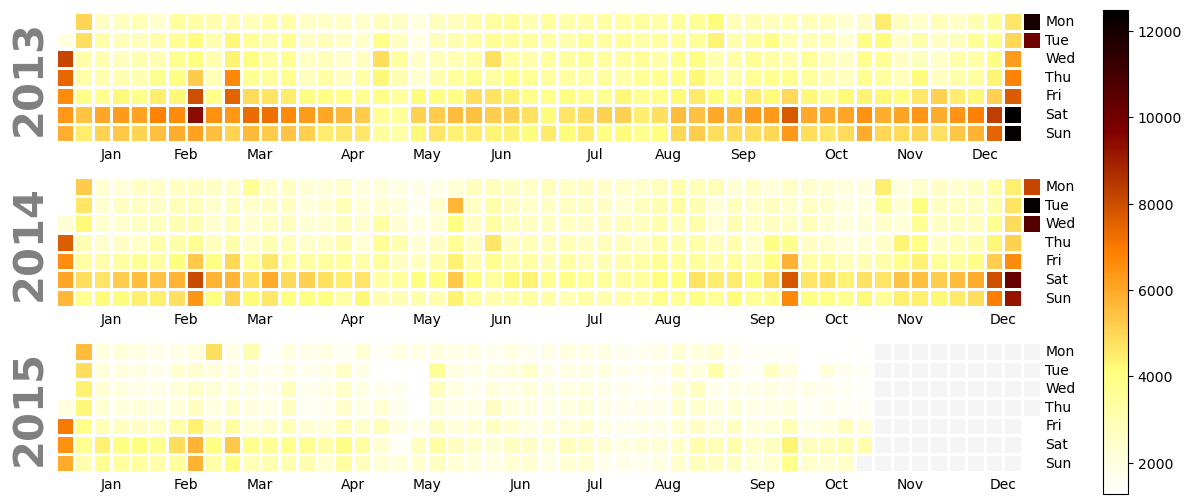

In [35]:

df = pd.DataFrame()
df['date'] = pd.to_datetime(data['sales_train']['date'].to_numpy(), yearfirst=True)
df['price'] = data['sales_train']['item_cnt_day'].to_numpy()
df= df.set_index('date')

calplot.calplot(df['price'], edgecolor=None, cmap='afmhot_r')

###### It can be seen that the sales increase at the end of the year, which most likely indicates the presence of seasonality. There is also a noticeable decrease in sales over time.

In [36]:
%%time
sales_data.date = mpd.to_datetime(sales_data.date)
sales_data['week_number'] = (sales_data.date - min(sales_data.date)).dt.days // 7
week_sales = mpd.DataFrame(sales_data.groupby(["week_number"])['item_cnt_day'].agg(sum))\
    .rename(columns={"item_cnt_day":"item_cnt_week"}).reset_index()
week_sales.describe()

CPU times: total: 3.92 s
Wall time: 4.71 s


week_number  item_cnt_week
count       148.00         148.00
mean         73.50       23793.32
std          42.87        7670.50
min           0.00        9924.00
25%          36.75       18818.25
50%          73.50       23662.00
75%         110.25       27255.50
max         147.00       62604.00

[Text(0.5, 0, 'Week number'),
 Text(0, 0.5, 'Amount'),
 Text(0.5, 1.0, 'Sales of all items per week')]

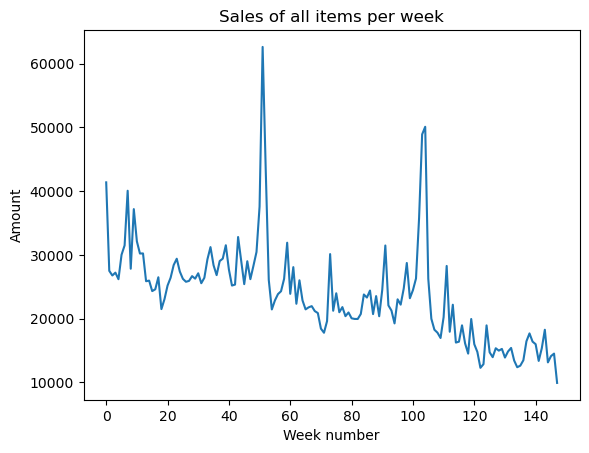

In [37]:
ax = sns.lineplot(x=week_sales.week_number.to_list(), y=week_sales.item_cnt_week.to_list())
ax.set(xlabel='Week number', ylabel="Amount", title="Sales of all items per week")

In [38]:
sales_data.head()

date  date_block_num  item_id  item_price  item_cnt_day  \
0 2013-01-02               0    22154      999.00          1.00   
1 2013-01-03               0     2552      899.00          1.00   
2 2013-01-05               0     2552      899.00          0.00   
3 2013-01-06               0     2554     1709.05          1.00   
4 2013-01-15               0     2555     1099.00          1.00   

   item_category_id                   item_category_name  month  week_number  
0                37                       Кино - Blu-Ray      1            0  
1                58                       Музыка - Винил      1            0  
2                58                       Музыка - Винил      1            0  
3                58                       Музыка - Винил      1            0  
4                56  Музыка - CD фирменного производства      1            2

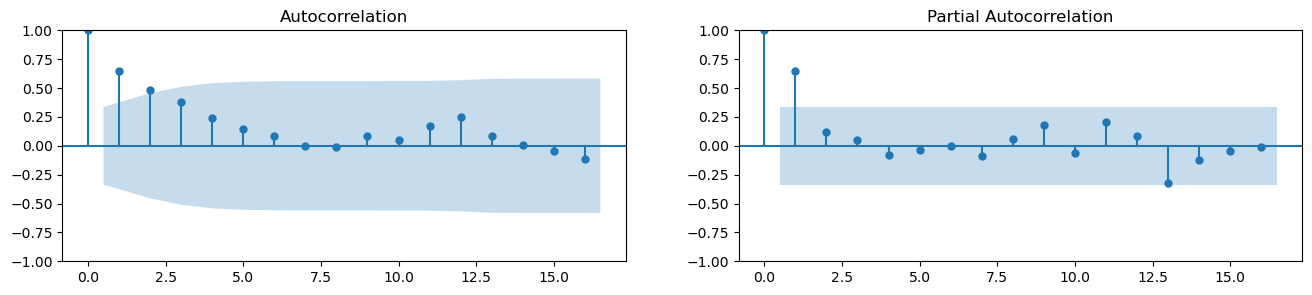

In [39]:


fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
axes[0] = plot_acf(month_sales['item_cnt_month'], lags=None, ax=axes[0])
axes[1] = plot_pacf(month_sales['item_cnt_month'], lags=None, ax=axes[1])

There is a seasonal dependence. Maybe need to try a lags of [1, 2, 3, 12] for months.

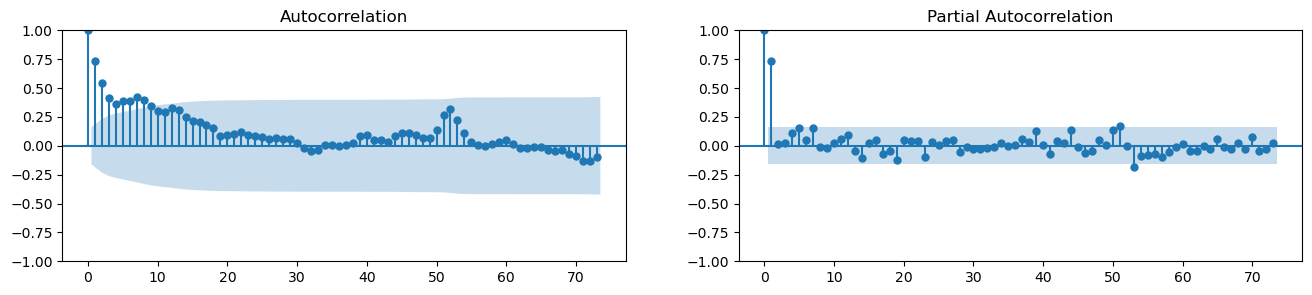

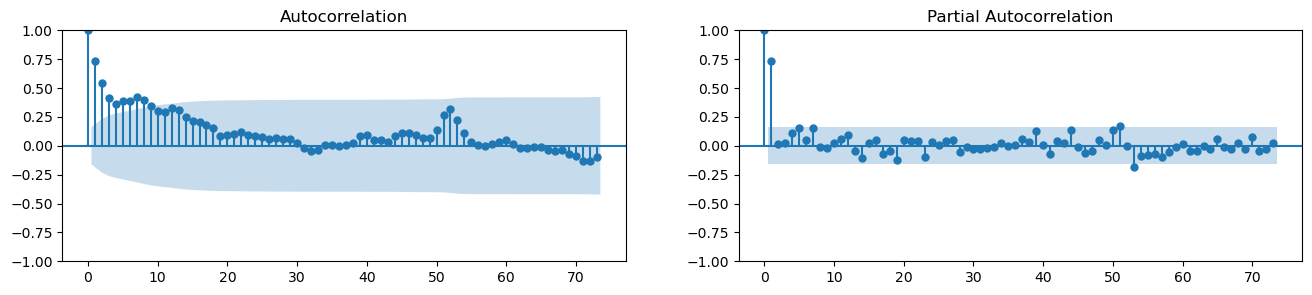

In [40]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(week_sales['item_cnt_week'], lags=73, ax=axes[0])
plot_pacf(week_sales['item_cnt_week'], lags=73, ax=axes[1])

Maybe need to try a lags of [1, 4, 7, 52] for weeks.

###### Check how month with same names correlated by sales

In [41]:
sales_data['year'] = sales_data.date.dt.year

In [42]:
g = sales_data.groupby(['week_number', 'year']).agg({'item_id': 'count'})\
    .reset_index().rename(columns={'item_id':'item_cnt_week'})

In [43]:
del(sales_data)

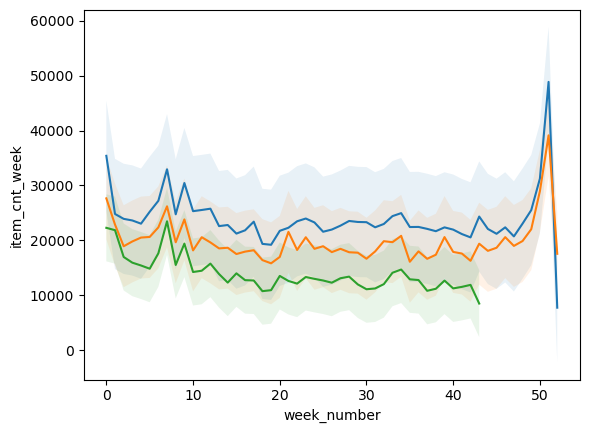

In [44]:
fig, ax = plt.subplots()
shift = 0
for year in g.year.unique():
    year_sample = g[g.year == year]
    ax = sns.lineplot(x=year_sample.week_number - shift*52, y=year_sample.item_cnt_week)
    temp_std = year_sample.item_cnt_week.std()
    ax = plt.fill_between(year_sample.week_number - shift*52,
                     year_sample.item_cnt_week - 1.96 * temp_std,
                     year_sample.item_cnt_week + 1.96 * temp_std,
                     alpha=0.1)
    shift += 1
#ax.set(xlabel='Week number', ylabel="Amount of sales", title="Sales of all items per year by week")

 Sales for every year looks similary for the same month. As mentioned earlier there is a decreasing trend in the number of sales (in 2015 sales are less than in previous years). No full information about green year (2015).

###### Check for shops with largest/smallest amount of sales

In [45]:
shop_sales_data = data['sales_train'].merge(
            data['items'], how='left', on='item_id'
        ).merge(
            data['item_categories'], how='left', on='item_category_id'
        ).merge(
           data['shops'], on='shop_id', how='left'
        )
shop_sales_data.head(2)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  2013-01-02               0       59    22154      999.00          1.00   
1  2013-01-03               0       25     2552      899.00          1.00   

  year_month                                 item_name  item_category_id  \
0    2013-01                         ЯВЛЕНИЕ 2012 (BD)                37   
1    2013-01  DEEP PURPLE  The House Of Blue Light  LP                58   

  item_category_name               shop_name  
0     Кино - Blu-Ray  Ярославль ТЦ "Альтаир"  
1     Музыка - Винил     Москва ТРК "Атриум"

In [46]:
%%time
shop_sales_data.loc[shop_sales_data.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shop_sales_data["shop_city"] = shop_sales_data.shop_name.str.split(" ").map(lambda x: x[0])
shop_sales_data["shop_category"] = shop_sales_data.shop_name.str.split(" ").map(lambda x: x[1])
shop_sales_data.loc[shop_sales_data.shop_city == "!Якутск", "shop_city"] = "Якутск"
shop_sales_data.head(2)

CPU times: total: 141 ms
Wall time: 205 ms


date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  2013-01-02               0       59    22154      999.00          1.00   
1  2013-01-03               0       25     2552      899.00          1.00   

  year_month                                 item_name  item_category_id  \
0    2013-01                         ЯВЛЕНИЕ 2012 (BD)                37   
1    2013-01  DEEP PURPLE  The House Of Blue Light  LP                58   

  item_category_name               shop_name  shop_city shop_category  
0     Кино - Blu-Ray  Ярославль ТЦ "Альтаир"  Ярославль            ТЦ  
1     Музыка - Винил     Москва ТРК "Атриум"     Москва           ТРК

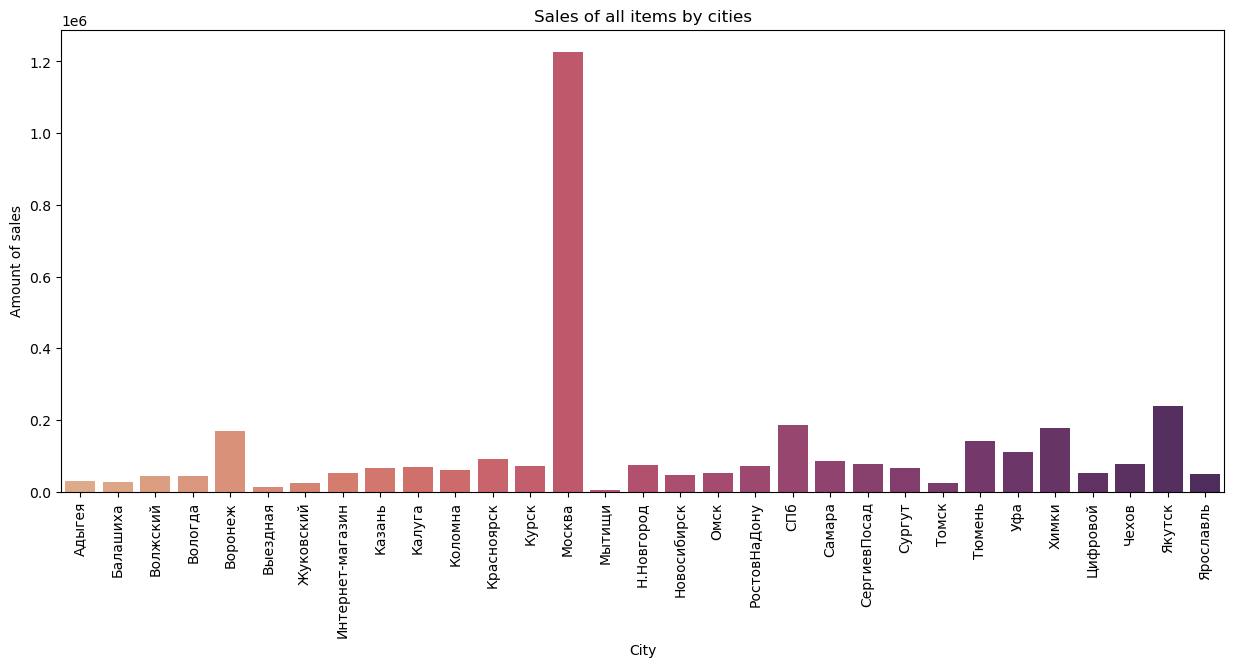

In [47]:
g = shop_sales_data.groupby('shop_city')['item_cnt_day'].agg(sum).reset_index()
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=g.shop_city.to_numpy(), y=g.item_cnt_day.to_numpy(), palette="flare")
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='City', ylabel="Amount of sales", title="Sales of all items by cities")
plt.show()

Moscow has extremely huge sales. Need to compare the number of stores

CPU times: total: 953 ms
Wall time: 8.51 s


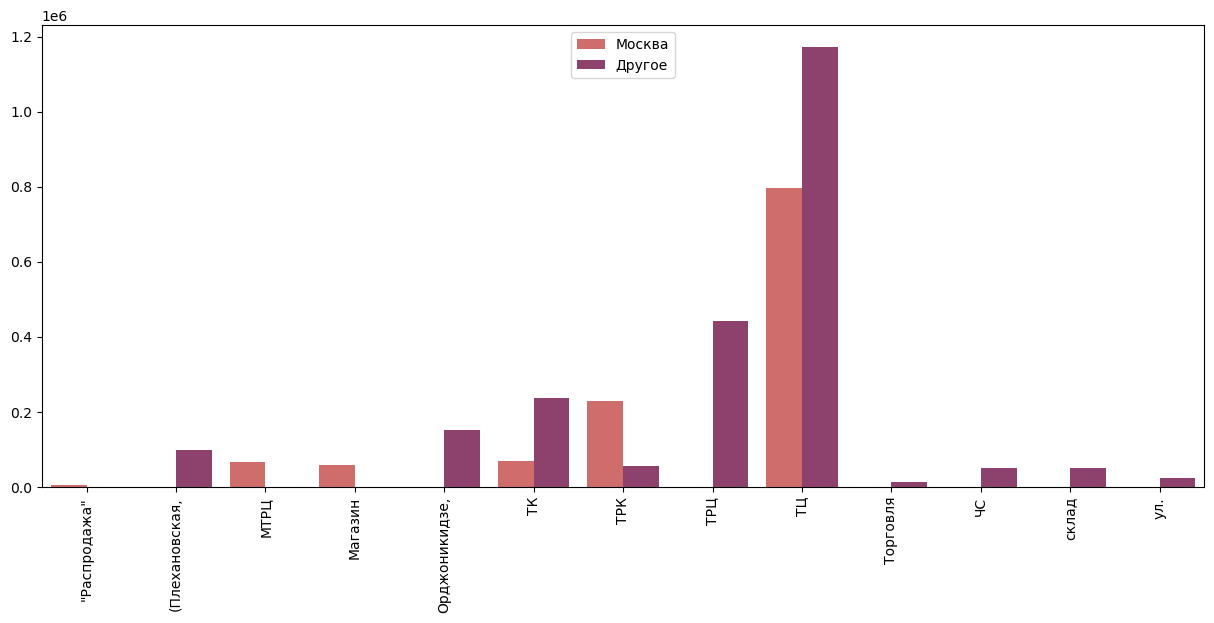

In [48]:
%%time
plt.figure(figsize=(15, 6))
shop_sales_data['is_Moscow'] = shop_sales_data['shop_city'].where(shop_sales_data.shop_city == 'Москва', other='Другое')
g = shop_sales_data.groupby(['shop_category', 'is_Moscow'])['item_cnt_day'].agg(sum).reset_index()
ax = sns.barplot(x=g.shop_category.to_numpy(), y=g.item_cnt_day.to_numpy(), palette="flare", hue=g.is_Moscow.to_numpy())
ax.tick_params(axis='x', rotation=90)

There are big part of shops located in Moscow, but some no, so it's hard to cluster it manually. Stores need to be clustered using algorithm.

###### Shops clasterization (try to cluster shops by sales)

In [49]:
to_clust_shops = shop_sales_data.groupby(['shop_name', 'date_block_num'])['item_id'].count().reset_index()\
    .pivot(index='shop_name', columns=['date_block_num']).fillna(0)

In [50]:
to_clust_shops.head()

date_block_num                      0       1       2      3       4       5   \
shop_name                                                                       
!Якутск Орджоникидзе, 56 фран  4793.00 5064.00    0.00   0.00    0.00    0.00   
!Якутск ТЦ "Центральный" фран  2694.00 2984.00    0.00   0.00    0.00    0.00   
Адыгея ТЦ "Мега"               1071.00  454.00  681.00 556.00  531.00  750.00   
Балашиха ТРК "Октябрь-Киномир"  749.00  761.00  889.00 628.00  673.00  728.00   
Волжский ТЦ "Волга Молл"       1894.00 1815.00 1811.00 256.00 1113.00 1305.00   

date_block_num                      6       7       8       9   ...      24  \
shop_name                                                       ...           
!Якутск Орджоникидзе, 56 фран     0.00    0.00    0.00    0.00  ...    0.00   
!Якутск ТЦ "Центральный" фран     0.00    0.00    0.00    0.00  ...    0.00   
Адыгея ТЦ "Мега"                768.00  792.00  735.00  633.00  ...  868.00   
Балашиха ТРК "Октябрь-Киномир"  668.00  824.00  825.00  723.00  ...  903.00   
Волжский ТЦ "Волга Молл"       1303.00 1599.00 1238.00 1240.00  ... 1041.00   

date_block_num                     25     26     27     28     29     30  \
shop_name                                                                  
!Якутск Орджоникидзе, 56 фран    0.00   0.00   0.00   0.00   0.00   0.00   
!Якутск ТЦ "Центральный" фран    0.00   0.00   0.00   0.00   0.00   0.00   
Адыгея ТЦ "Мега"               765.00 634.00 624.00 635.00 730.00 738.00   
Балашиха ТРК "Октябрь-Киномир" 691.00 702.00 604.00 648.00 642.00 515.00   
Волжский ТЦ "Волга Молл"       855.00 869.00 720.00 741.00 738.00 789.00   

date_block_num                     31     32     33  
shop_name                                            
!Якутск Орджоникидзе, 56 фран    0.00   0.00   0.00  
!Якутск ТЦ "Центральный" фран    0.00   0.00   0.00  
Адыгея ТЦ "Мега"               844.00 670.00 637.00  
Балашиха ТРК "Октябрь-Киномир" 603.00 565.00 546.00  
Волжский ТЦ "Волга Молл"       838.00 644.00 704.00  

[5 rows x 34 columns]

In [51]:
dim_reducer = umap.UMAP(n_neighbors=5, min_dist=0.2, n_components=2, metric='cosine', random_state=42)
clusterizer = DBSCAN(metric='l2', eps=2)

[Text(0.5, 1.0, 'Shops cosine similarity by sales')]

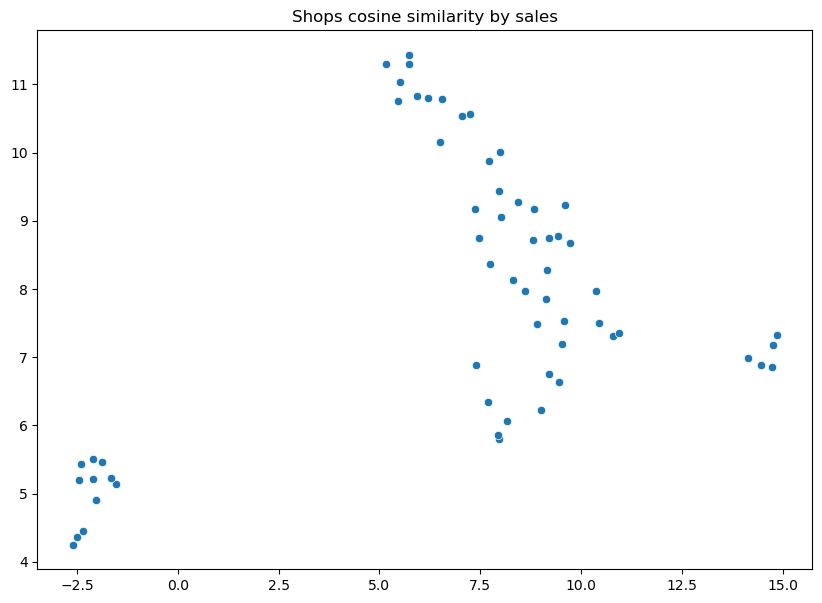

In [52]:
shop_embeddings = dim_reducer.fit_transform(to_clust_shops)

clusterizer.fit(shop_embeddings)
clusters = pd.DataFrame({'cluster_id': clusterizer.labels_, 'cluster_item_id': list(to_clust_shops.index)})

fig, axs = plt.subplots(figsize=(10, 7))

ax = sns.scatterplot(x=shop_embeddings.transpose()[0], y=shop_embeddings.transpose()[1], ax=axs)
ax.set(title='Shops cosine similarity by sales')

Checking is clusterization valid or no

In [53]:
clusters = clusters.rename(columns={"cluster_item_id":"shop_name"})
shop_clusters = shop_sales_data.groupby(['shop_name', 'date_block_num'])['item_id'].count()\
        .reset_index().rename(columns={"cluster_item_id":"shop_name", "item_id":"sales_amount"})\
        .merge(mpd.DataFrame(clusters), on='shop_name', how='left').sort_values(by=['sales_amount', 'date_block_num'])

In [54]:
shop_clusters[shop_clusters.cluster_id == 2].head(3)

shop_name  date_block_num  sales_amount  cluster_id
213     Выездная Торговля              27             1           2
839     Мытищи ТРК "XL-3"              27             1           2
840  Н.Новгород ТРЦ "РИО"              18             2           2

In [55]:
shop_clusters[shop_clusters.cluster_id == 1].head(3)

shop_name  date_block_num  sales_amount  cluster_id
700  Москва ТЦ "МЕГА Белая Дача II"              32             1           1
674  Москва ТЦ "МЕГА Белая Дача II"               5           185           1
302             Казань ТЦ "Бехетле"              19           199           1

In [56]:
shop_clusters[shop_clusters.cluster_id == 0].head(3)

shop_name  date_block_num  sales_amount  cluster_id
210  Воронеж ТРЦ Сити-Парк "Град"               3             1           0
830    Москва ТЦ "Серебряный Дом"               6            89           0
209  Воронеж ТРЦ Сити-Парк "Град"               2           930           0

Another clusterization by sales

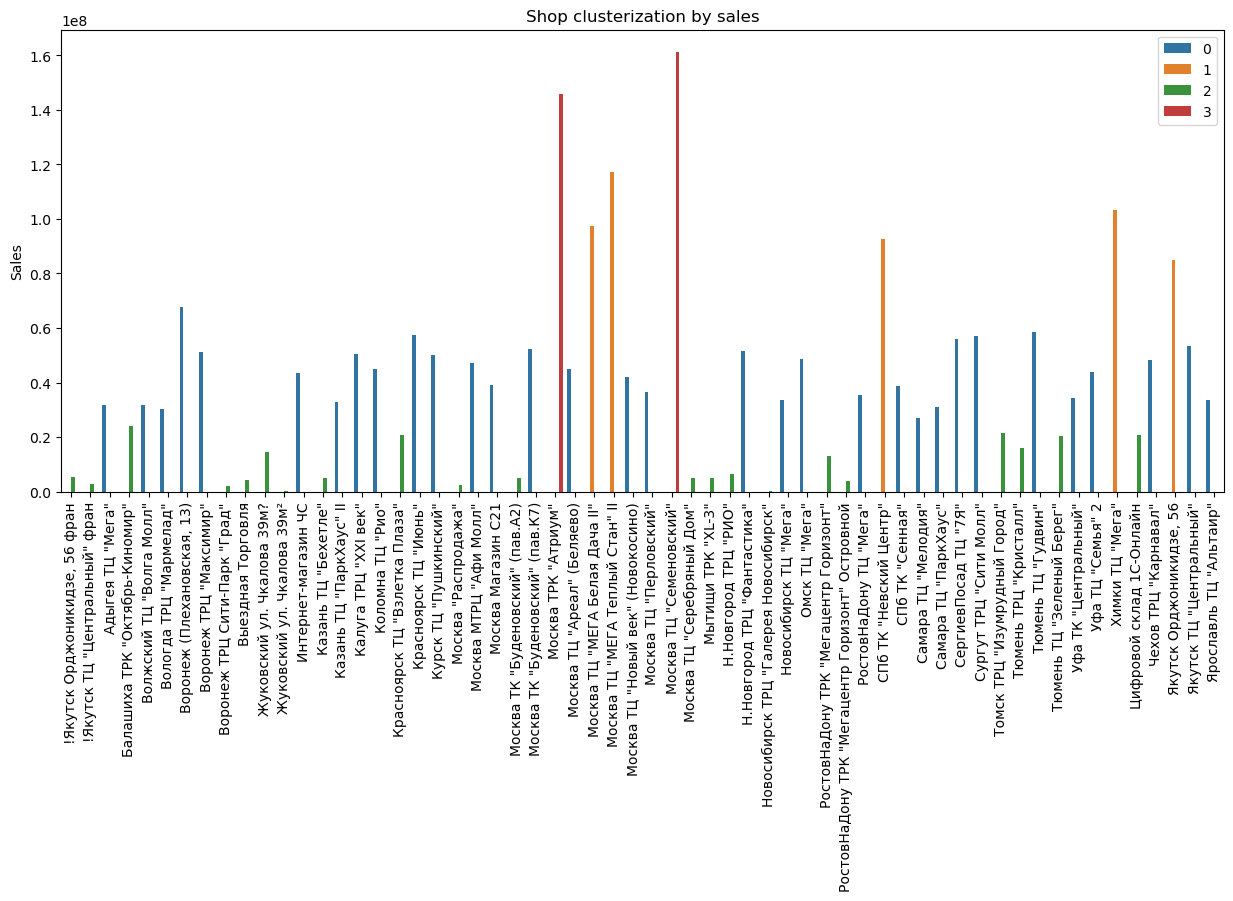

In [57]:
# group shops by sales
to_clust_shops = shop_sales_data.groupby(['shop_name'])['item_price'].agg(sum).reset_index()

# clustering
km = KMeans(n_clusters= 4, random_state=42, n_init="auto").fit(to_clust_shops.item_price.to_numpy().reshape(-1, 1))
labels = mpd.DataFrame(km.labels_, columns=['cluster_id'])
clusters_info = mpd.concat([to_clust_shops, labels], axis=1)
clusters_info = clusters_info.rename(columns={"item_price":"sales_amount"})

#visualization
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=clusters_info["shop_name"].to_numpy(), y=clusters_info["sales_amount"].to_numpy(),
            hue=clusters_info["cluster_id"].to_numpy())
ax.set_title("Shop clusterization by sales")
ax.set_ylabel("Sales")
cnt = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Check is there enough information about each shop

[Text(0.5, 0, 'Amount of store records'),
 Text(0, 0.5, 'Amount of shops'),
 Text(0.5, 1.0, 'Histogram of store records')]

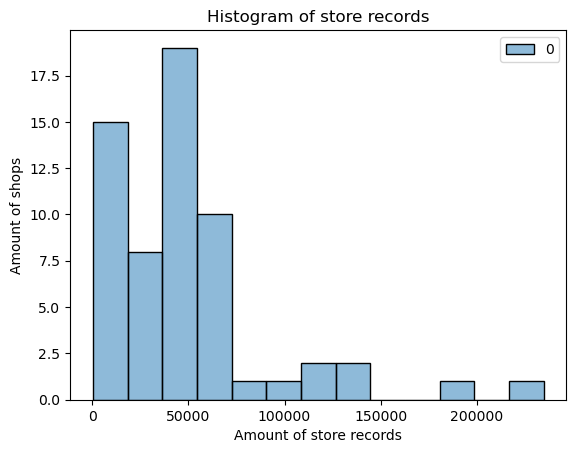

In [58]:
g = shop_sales_data.groupby('shop_id').agg({'date':'count'})
ax = sns.histplot(g)
ax.set(xlabel='Amount of store records', ylabel="Amount of shops", title="Histogram of store records")

Check amount of records for each shop

In [59]:
# add for all shops amount of records
shop_records = shop_sales_data.groupby('shop_id').agg({'date':'count'}).rename(columns={"date":"records_amount"}).reset_index()

In [60]:
shop_records = shop_records.merge(data['shops'], on='shop_id', how='right')

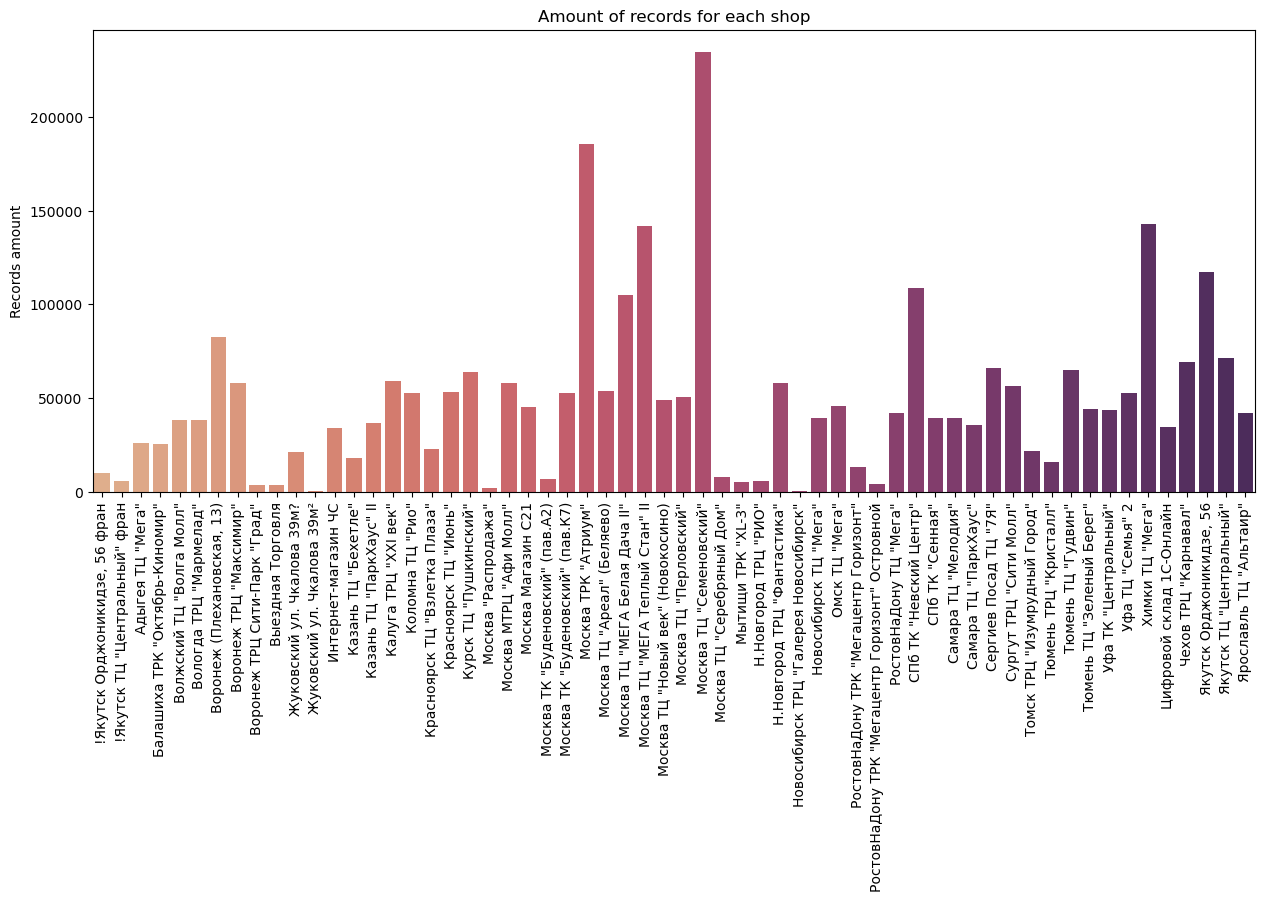

In [61]:
#visualization
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=shop_records["shop_name"].to_numpy(), y=shop_records["records_amount"].to_numpy(), palette='flare')
ax.set_title("Amount of records for each shop")
ax.set_ylabel("Records amount")
cnt = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

A lot of shops have really poor information of sales (maybe some shops closed in this 3 year interval or they are not popular at all). Maybe need to make a features like first sale of item and last sale of item.

Check how items/categories of items distributed by cities

Dynamic plot

In [62]:
import plotly.express as px

In [63]:
df = data['sales_train'].merge(
        data['items'], how='left', on='item_id'
        ).merge(
                data['item_categories'], how='left', on='item_category_id'
                ).merge(
                        data['shops'], how='left', on='shop_id'
                        ).drop(columns=['year_month', 'item_name'])
df["shop_city"] = df.shop_name.str.split(" ").map(lambda x: x[0])
df["shop_category"] = df.shop_name.str.split(" ").map(lambda x: x[1])
df.loc[df.shop_city == "!Якутск", "shop_city"] = "Якутск"
df.loc[df.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
df = df.groupby(['shop_city', 'item_category_id']).agg({'item_price':'sum', 'item_cnt_day':'sum'}).reset_index().sort_values(by=['item_price']).\
    merge(data['item_categories'], on='item_category_id', how='left')
df["type_code"] = df.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)
df["split"] = df.item_category_name.apply(lambda x: x.split("-"))
df["subtype"] = df.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df = df.drop(columns=['split'])
df1 = df.groupby(['shop_city', 'item_category_name']).agg({'item_price':'sum', 'item_cnt_day':'sum'}).reset_index().sort_values(by='item_cnt_day')

In [64]:
fig = px.bar(
    x=df1["item_cnt_day"].to_numpy(),
    y=df1["item_category_name"].to_numpy(),
    animation_frame=df1["shop_city"].to_numpy(),
    range_x=[100, 100000],
    range_y=[25,90]
)

fig.update_layout(
    width=800,
    height=600
)

fig.show()

Tile plot

In [65]:
df1.head()

shop_city                        item_category_name  item_price  \
853             Мытищи                            Музыка - Винил     2999.00   
935        Новосибирск                            Билеты (Цифра)     1500.00   
444   Интернет-магазин  Подарки - Сумки, Альбомы, Коврики д/мыши       28.00   
450   Интернет-магазин                   Чистые носители (шпиль)      350.00   
1247           Сергиев                     Игровые консоли - PS4      999.00   

      item_cnt_day  
853           1.00  
935           1.00  
444           1.00  
450           1.00  
1247          1.00

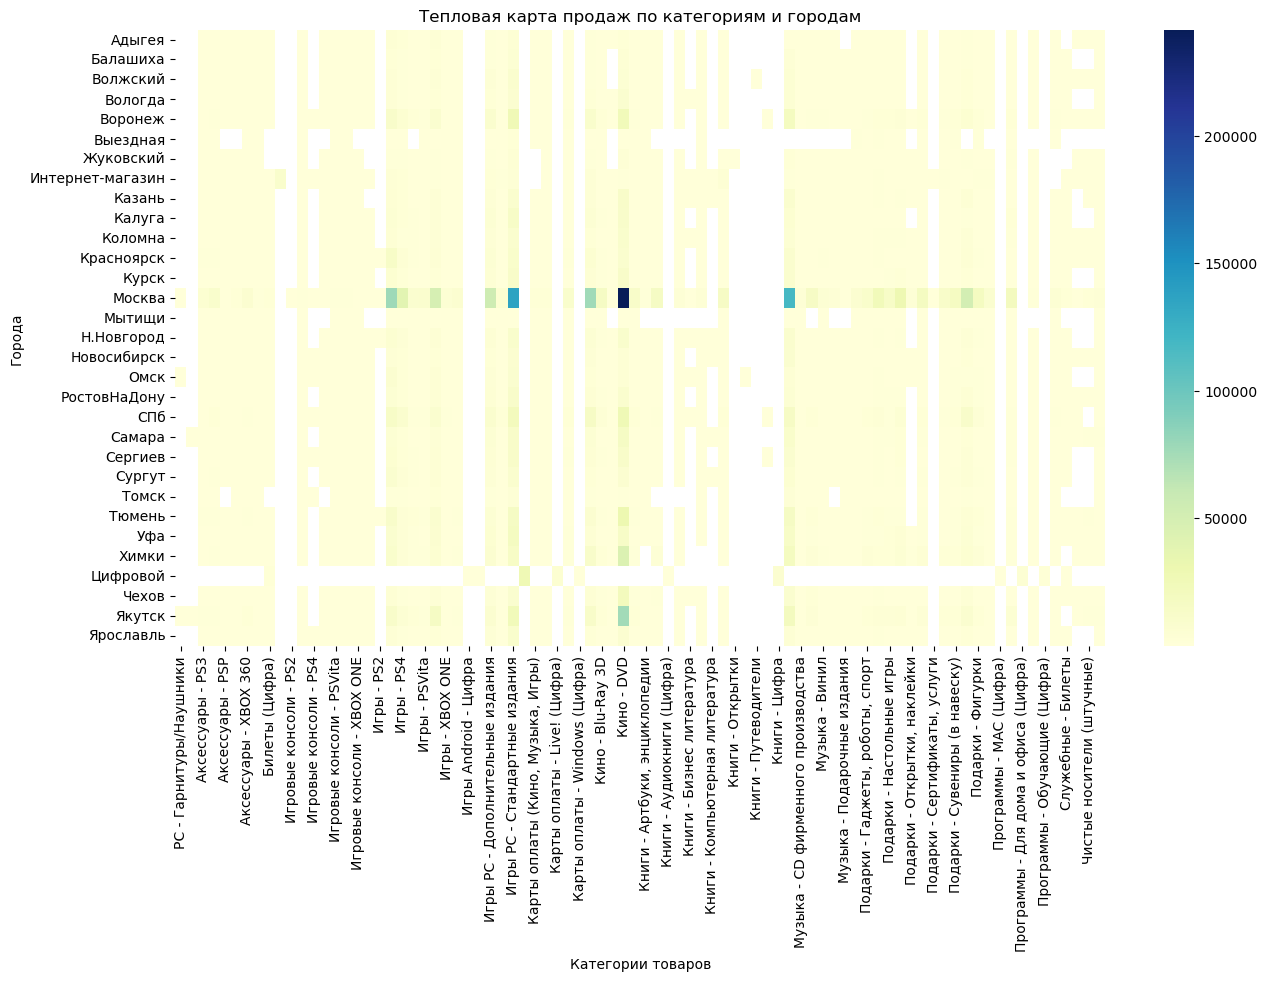

In [66]:
df = {
    'shop_city': df1.shop_city.to_numpy(),
    'item_cat': df1.item_category_name.to_numpy(),
    'item_cnt_day': df1.item_cnt_day.to_numpy()
}

df = pd.DataFrame(df)

pivot_table = df.pivot_table(values='item_cnt_day', index='shop_city', columns='item_cat')

plt.figure(figsize=(15, 8))
sns.heatmap(data=pivot_table, annot=False, cmap='YlGnBu')
plt.title('Тепловая карта продаж по категориям и городам')
plt.xlabel('Категории товаров')
plt.ylabel('Города')
plt.show()



1. Most sales in many categories are concentrated in Moscow
2. Most Popular Movie DVD Sales Category
3. There are categories of goods that were not sold in most stores (PC, PS2, PS4, Android, many kinds of books, certificates & services, some soft stuff)
4. "Цифровой" (online shop) has records for only a small number of categories(and this categories has mark as "(Цифра)")

Сumulative area for cities

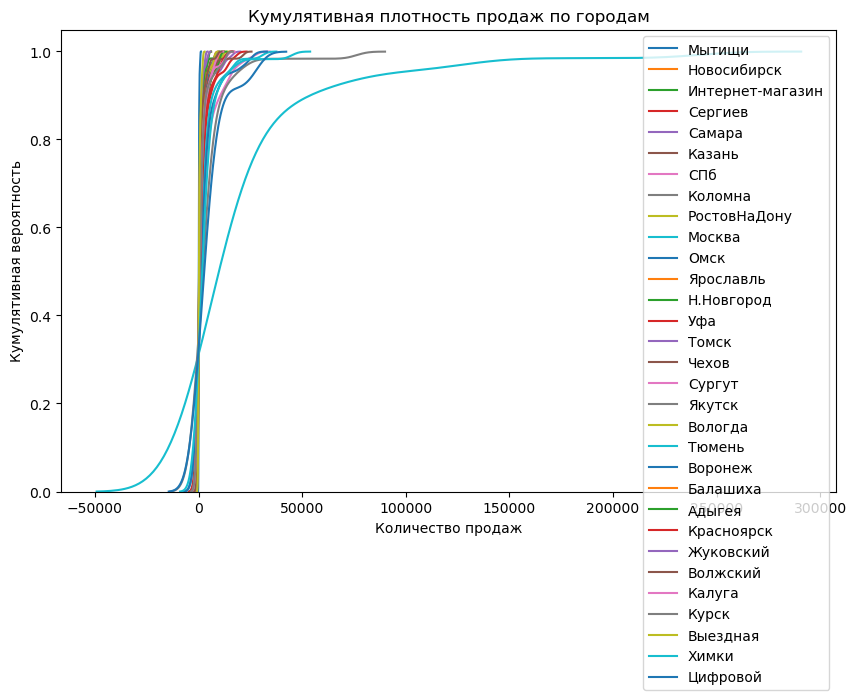

In [67]:
df = {
    'shop_city': df1.shop_city.to_numpy(),
    'item_cnt_day':  df1.item_cnt_day.to_numpy()
}

df = pd.DataFrame(df)

plt.figure(figsize=(10, 6))
for city in df['shop_city'].unique():
    sns.kdeplot(df[df['shop_city'] == city]['item_cnt_day'], cumulative=True, label=city)

plt.title('Кумулятивная плотность продаж по городам')
plt.xlabel('Количество продаж')
plt.ylabel('Кумулятивная вероятность')
plt.legend()
plt.show()


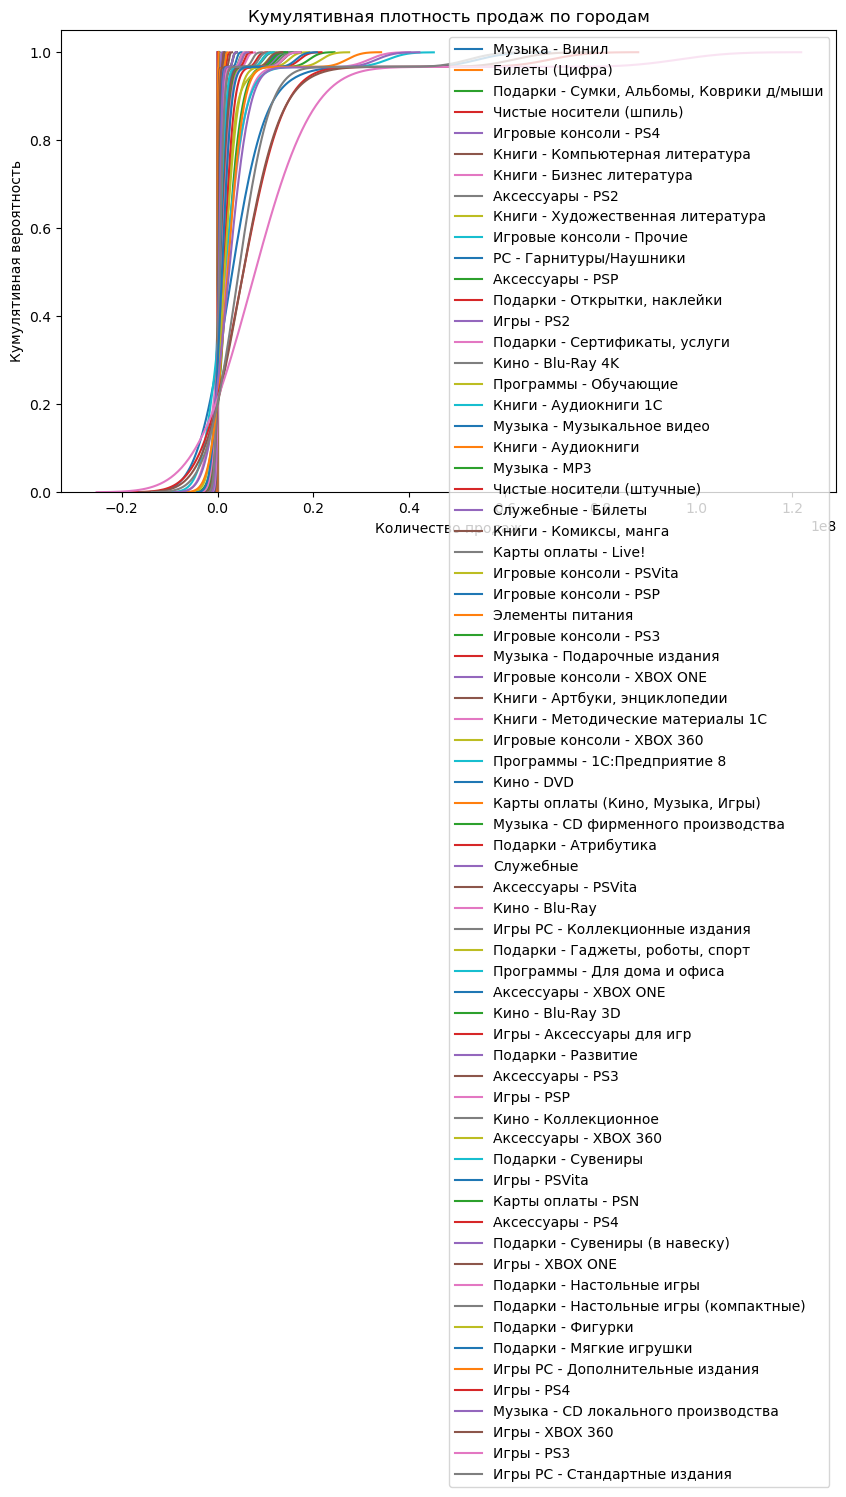

In [68]:
df = {
    'item_categories': df1.item_category_name.to_numpy(),
    'item_price':  df1.item_price.to_numpy()
}

df = pd.DataFrame(df)

plt.figure(figsize=(10, 6))
for city in df['item_categories'].unique():
    sns.kdeplot(df[df['item_categories'] == city]['item_price'], cumulative=True, label=city)

plt.title('Кумулятивная плотность продаж по городам')
plt.xlabel('Количество продаж')
plt.ylabel('Кумулятивная вероятность')
plt.legend()
plt.show()


###### Correlation matrix

In [69]:
to_clust_shops.head()

shop_name  item_price
0   !Якутск Орджоникидзе, 56 фран  5553869.00
1   !Якутск ТЦ "Центральный" фран  2926161.00
2                Адыгея ТЦ "Мега" 31741081.49
3  Балашиха ТРК "Октябрь-Киномир" 24216274.78
4        Волжский ТЦ "Волга Молл" 31923115.50

In [70]:
data['sales_train'].groupby(['date_block_num']).agg({'item_price': 'sum', 'item_id': 'count'}).corr()

item_price  item_id
item_price        1.00     0.77
item_id           0.77     1.00

As item counts and price of items have linear dependence it can go to the problem of multicollinearity so need to do smth with this labels in data preproccesing if we going to train linear model (like remove one of this label) 

Checked for items with no information

1. Number of good pairs: 111105
2. No data items: 15750
3. Only item_id info: 87345


[Text(0, 0, '0.5187'), Text(0, 0, '0.0735'), Text(0, 0, '0.4078')]

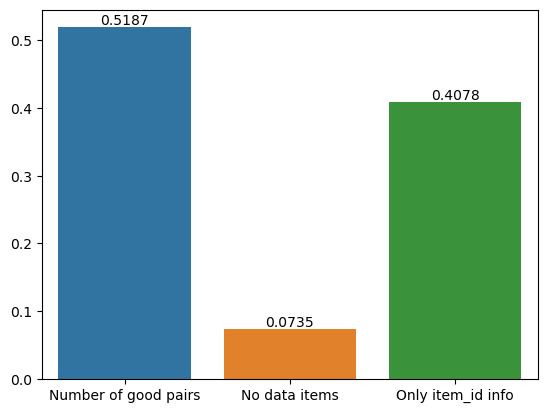

In [71]:
# calculating
good_sales = data['test'].merge(data['sales_train'], on=['item_id','shop_id'], how='left').dropna()
good_pairs = data['test'][data['test']['ID'].isin(good_sales['ID'])]
no_data_items = data['test'][~(data['test']['item_id'].isin(data['sales_train']['item_id']))]

# output
print('1. Number of good pairs:', len(good_pairs))
print('2. No data items:', len(no_data_items))
print('3. Only item_id info:', len(data['test'])-len(no_data_items)-len(good_pairs))

# visualization
d = { 'Number of good pairs': [len(good_pairs) / len(data['test'])],
      'No data items' : [len(no_data_items) / len(data['test'])],
      'Only item_id info' : [(len(data['test'])-len(no_data_items)-len(good_pairs)) / len(data['test'])]}
ax = sns.barplot(pd.DataFrame(d))
ax.bar_label(ax.containers[0], fmt='%.4f')

We have few items with no information (7.35%), and a lot of items for which we have sales information but not for a link to a specific shop, which we will need to predict (40.78%)

### Conclusions

1. In raw dataset, clearly see the time effect on sales (seasonality especially). 
2. Different categories of items have different marketability, so they were divided into several types (high-selling, medium-selling, low-selling and rarely selling)
3. Different categories of stores also have different marketability, but it is difficult to separate manually. Therefore, clustering was applied, which divided the stores by saleability based on the cosine distance into 3 categories
4. Clustered items by price
5. Based on the autocorrelation and partial autocorrelation graphs, it was customary to use lags of 1 month as useful features like a lag of [1, 2, 3, 12] for months and lag of [1, 4, 7, 52] for weeks
6. Months with the highest sales fall on the 9th, 10th, 11th, 12th month.
7. A lot of shops have really poor information of sales (maybe some shops closed in this 3 year interval or they are not popular at all). Maybe need to make a features like first sale of item and last sale of item.
8. No correlation between price of item and item sales (?)
9. There are multicollinearity based on items price and items count sales.
10. We have few items with no information (7.35%), and a lot of items for which we have sales information but not for a link to a specific shop, which we will need to predict (40.78%)

### Data preproccesing

###### Build pretrained data

In [72]:
# combinate month, shop and item in order of increasing month
pretrained_data  = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = data['sales_train'][data['sales_train'].date_block_num == i]
    pretrained_data.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique()))))

pretrained_data = mpd.DataFrame(np.vstack(pretrained_data), columns = cols )
pretrained_data.sort_values(cols, inplace = True)

# merge datasets for data preprocessing
pretrained_data = mpd.merge(pretrained_data, data['shops'], on = ["shop_id"], how = "left" )
pretrained_data = mpd.merge(pretrained_data, data['items'], on = ["item_id"], how = "left")
pretrained_data = mpd.merge(pretrained_data, data['item_categories'], on = ["item_category_id"], how = "left" )

In [73]:
# add profit from sales
pretrained_data["profit"] = data['sales_train']["item_cnt_day"] * data['sales_train']["item_price"]

In [74]:
# add count of sold items per month
group = data['sales_train'].groupby(["date_block_num", "shop_id", "item_id"]).agg({"item_cnt_day": ["sum"]})
group.columns = ["item_cnt_month"]
group.reset_index(inplace = True)
pretrained_data = mpd.merge(pretrained_data, group, on = cols, how = "left")
pretrained_data["item_cnt_month"] = pretrained_data["item_cnt_month"].fillna(0)

In [75]:
pretrained_data.head(2)

date_block_num  shop_id  item_id                      shop_name  \
0               0        0       19  !Якутск Орджоникидзе, 56 фран   
1               0        0       27  !Якутск Орджоникидзе, 56 фран   

                           item_name  item_category_id item_category_name  \
0          /ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72                40         Кино - DVD   
1  007 Legends [PS3, русская версия]                19         Игры - PS3   

   profit  item_cnt_month  
0  999.00            0.00  
1  899.00            0.00

###### Substruct some categories from string data 

In [76]:
# item categories data
pretrained_data["type_code"] = pretrained_data.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)
pretrained_data.type_code = LabelEncoder().fit_transform(pretrained_data.type_code)

In [77]:
pretrained_data.head(2)

date_block_num  shop_id  item_id                      shop_name  \
0               0        0       19  !Якутск Орджоникидзе, 56 фран   
1               0        0       27  !Якутск Орджоникидзе, 56 фран   

                           item_name  item_category_id item_category_name  \
0          /ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72                40         Кино - DVD   
1  007 Legends [PS3, русская версия]                19         Игры - PS3   

   profit  item_cnt_month  type_code  
0  999.00            0.00          7  
1  899.00            0.00          5

In [78]:
pretrained_data["split"] = pretrained_data.item_category_name.apply(lambda x: x.split("-"))
pretrained_data["subtype"] = pretrained_data.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
pretrained_data["subtype_code"] = LabelEncoder().fit_transform(pretrained_data["subtype"])
pretrained_data = pretrained_data.drop(columns=['item_category_name', 'split', 'subtype'])

In [79]:
pretrained_data.head(2)

date_block_num  shop_id  item_id                      shop_name  \
0               0        0       19  !Якутск Орджоникидзе, 56 фран   
1               0        0       27  !Якутск Орджоникидзе, 56 фран   

                           item_name  item_category_id  profit  \
0          /ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72                40  999.00   
1  007 Legends [PS3, русская версия]                19  899.00   

   item_cnt_month  type_code  subtype_code  
0            0.00          7             4  
1            0.00          5            10

In [80]:
%%time
# shops data
pretrained_data["shop_city"] = pretrained_data.shop_name.str.split(" ").map(lambda x: x[0])
pretrained_data["shop_category"] = pretrained_data.shop_name.str.split(" ").map(lambda x: x[1])
pretrained_data["shop_category"] = LabelEncoder().fit_transform(pretrained_data.shop_category)
pretrained_data["shop_city"] = LabelEncoder().fit_transform(pretrained_data.shop_city)
pretrained_data = pretrained_data.drop(columns=['shop_name'])

CPU times: total: 7.22 s
Wall time: 1min 2s


In [81]:
pretrained_data.head(2)

date_block_num  shop_id  item_id                          item_name  \
0               0        0       19          /ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72   
1               0        0       27  007 Legends [PS3, русская версия]   

   item_category_id  profit  item_cnt_month  type_code  subtype_code  \
0                40  999.00            0.00          7             4   
1                19  899.00            0.00          5            10   

   shop_city  shop_category  
0          0              4  
1          0              4

In [82]:
# item data
pretrained_data["name1"], pretrained_data["name2"] = pretrained_data.item_name.str.split('[', n=1).str[0], pretrained_data.item_name.str.split('[', n=1).str[1]
pretrained_data["name1"], pretrained_data["name3"] = pretrained_data.item_name.str.split('(', n=1).str[0], pretrained_data.item_name.str.split('(', n=1).str[1]

# replace special characters and turn to lower case
pretrained_data["name2"] = pretrained_data.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
pretrained_data["name3"] = pretrained_data.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

pretrained_data = pretrained_data.fillna('0')

pretrained_data.name2 = LabelEncoder().fit_transform(pretrained_data.name2)
pretrained_data.name3 = LabelEncoder().fit_transform(pretrained_data.name3)

pretrained_data = pretrained_data.drop(columns=['name1', 'item_name']) 

In [83]:
pretrained_data.head(2)

date_block_num  shop_id  item_id  item_category_id profit  item_cnt_month  \
0               0        0       19                40 999.00            0.00   
1               0        0       27                19 899.00            0.00   

   type_code  subtype_code  shop_city  shop_category  name2  name3  
0          7             4          0              4      5     40  
1          5            10          0              4     77     40

###### time series features

In [84]:
def extract_lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = mpd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [85]:
%%time
# item count per month lag
pretrained_data = extract_lag_feature(pretrained_data, [1, 2, 3, 12], 'item_cnt_month')

CPU times: total: 4.08 s
Wall time: 41.3 s


In [86]:
pretrained_data.head()

date_block_num  shop_id  item_id  item_category_id  profit  item_cnt_month  \
0               0        0       19                40  999.00            0.00   
1               0        0       27                19  899.00            0.00   
2               0        0       28                30    0.00            0.00   
3               0        0       29                23 1709.05            0.00   
4               0        0       32                40 1099.00            6.00   

   type_code  subtype_code  shop_city  shop_category  name2  name3  \
0          7             4          0              4      5     40   
1          5            10          0              4     77     40   
2          5            55          0              4    110     40   
3          5            16          0              4    124     40   
4          7             4          0              4      5     40   

   item_cnt_month_lag_1  item_cnt_month_lag_2  item_cnt_month_lag_3  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   item_cnt_month_lag_12  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

In [87]:
# lag of average item count sales per month 

group = pretrained_data.groupby(["date_block_num"] ).agg({"item_cnt_month" : "mean"})
group.columns = ["avg_by_month_item_cnt"]
group.reset_index()


pretrained_data = mpd.merge(pretrained_data, group, on = ["date_block_num"], how = "left")
del(group)
pretrained_data = extract_lag_feature(pretrained_data, [1, 2, 3], "avg_by_month_item_cnt")
pretrained_data.drop(["avg_by_month_item_cnt"], axis = 1, inplace = True)

In [88]:
pretrained_data.head(2)

date_block_num  shop_id  item_id  item_category_id profit  item_cnt_month  \
0               0        0       19                40 999.00            0.00   
1               0        0       27                19 899.00            0.00   

   type_code  subtype_code  shop_city  shop_category  name2  name3  \
0          7             4          0              4      5     40   
1          5            10          0              4     77     40   

   item_cnt_month_lag_1  item_cnt_month_lag_2  item_cnt_month_lag_3  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   

   item_cnt_month_lag_12  avg_by_month_item_cnt_lag_1  \
0                    NaN                          NaN   
1                    NaN                          NaN   

   avg_by_month_item_cnt_lag_2  avg_by_month_item_cnt_lag_3  
0                          NaN                          NaN  
1                          NaN                          NaN

In [89]:
# lag of average item sales per month of each id

group = pretrained_data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': 'mean'})
group.columns = ['avg_by_month_item_id_item_cnt']
group = group.reset_index()


pretrained_data = mpd.merge(pretrained_data, group, on=['date_block_num', 'item_id'], how='left')
del(group)
pretrained_data = extract_lag_feature(pretrained_data, [1, 2, 3, 12], "avg_by_month_item_id_item_cnt")
pretrained_data.drop(columns = ['avg_by_month_item_id_item_cnt'], axis = 1, inplace = True)

In [90]:
pretrained_data.tail(2)

date_block_num  shop_id  item_id  item_category_id profit  \
10902922              33       59    22166                54      0   
10902923              33       59    22167                49      0   

          item_cnt_month  type_code  subtype_code  shop_city  shop_category  \
10902922            0.00          8            61         31              9   
10902923            0.00          8            39         31              9   

          ...  item_cnt_month_lag_2  item_cnt_month_lag_3  \
10902922  ...                  0.00                  0.00   
10902923  ...                  0.00                  0.00   

          item_cnt_month_lag_12  avg_by_month_item_cnt_lag_1  \
10902922                   0.00                         0.30   
10902923                   0.00                         0.30   

          avg_by_month_item_cnt_lag_2  avg_by_month_item_cnt_lag_3  \
10902922                         0.31                         0.28   
10902923                         0.31                         0.28   

          avg_by_month_item_id_item_cnt_lag_1  \
10902922                                 0.12   
10902923                                 0.49   

          avg_by_month_item_id_item_cnt_lag_2  \
10902922                                 0.26   
10902923                                 0.69   

          avg_by_month_item_id_item_cnt_lag_3  \
10902922                                 0.19   
10902923                                 0.79   

          avg_by_month_item_id_item_cnt_lag_12  
10902922                                  0.23  
10902923                                  0.94  

[2 rows x 23 columns]

In [ ]:
# lag of average item sales per month of each shop

group = pretrained_data.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': 'mean'})
group.columns = ['avg_by_month_shop_item_cnt']
group = group.reset_index()

pretrained_data = mpd.merge(pretrained_data, group, on=['date_block_num', 'shop_id'], how='left')

pretrained_data = extract_lag_feature(pretrained_data, [1,2,3], "avg_by_month_shop_item_cnt")
pretrained_data.drop(columns = ['avg_by_month_shop_item_cnt'], axis = 1, inplace = True)

In [ ]:
pretrained_data.tail(2)

In [ ]:
# lag of average item sales per month of each city

group = pretrained_data.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': 'mean'})
group.columns = ['avg_by_month_city_item_cnt']
group = group.reset_index()


pretrained_data = mpd.merge(pretrained_data, group, on=['date_block_num', 'shop_city'], how='left')
del(group)
pretrained_data = extract_lag_feature( pretrained_data, [1], "avg_by_month_city_item_cnt" )
pretrained_data.drop(columns = ['avg_by_month_city_item_cnt'], axis = 1, inplace = True)

In [ ]:
pretrained_data.tail(2)

In [ ]:
# lag of average item sales per month of each category

group = pretrained_data.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': 'mean'})
group.columns = ['avg_by_month_cat_item_cnt']
group = group.reset_index()


pretrained_data = mpd.merge(pretrained_data, group, on=['date_block_num', 'item_category_id'], how='left')
del(group)
pretrained_data = extract_lag_feature(pretrained_data, [1], "avg_by_month_cat_item_cnt")
pretrained_data.drop(columns = ['avg_by_month_cat_item_cnt'], axis = 1, inplace = True)

In [ ]:
pretrained_data.tail(2)

###### Add clusters features

In [ ]:
# price clusters

In [ ]:
# shop clusters

In [ ]:
# categories cluster

In [ ]:
# split good_pairs only item_id info?

###### Other usefull features

1. mean of price by month
2. item first sale
3. item last sale
4. change of sales of item/price by month